In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [2]:
import warnings
warnings.filterwarnings('ignore', '', UserWarning)

Data dictionary : https://share.getcloudapp.com/v1uxOr4Y  
Variable notes: https://share.getcloudapp.com/2NujmBEw  
Kaggle competition: https://www.kaggle.com/c/titanic/data

# Getting the data

In [3]:
train_data = pd.read_csv("https://raw.githubusercontent.com/fabricio21x/introduction-to-ml/main/datasets/titanic_train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/fabricio21x/introduction-to-ml/main/datasets/titanic_test.csv")

# Performing Exploratory Data Analysis (EDA)

In [4]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


### Let's look for patterns in the data

In [6]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women*100)

% of women who survived: 74.20382165605095


In [7]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men*100)

% of men who survived: 18.890814558058924


We see that 75% of the survivors in the train set are women, so it wouldn't be crazy to say that only women will survive in our test set... right?

### Lets check the survivability rate 


In [8]:
surv_rate = train_data["Survived"].mean()
print(f"The survivability rate is: {surv_rate*100:.2f}%")

The survivability rate is: 38.38%


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


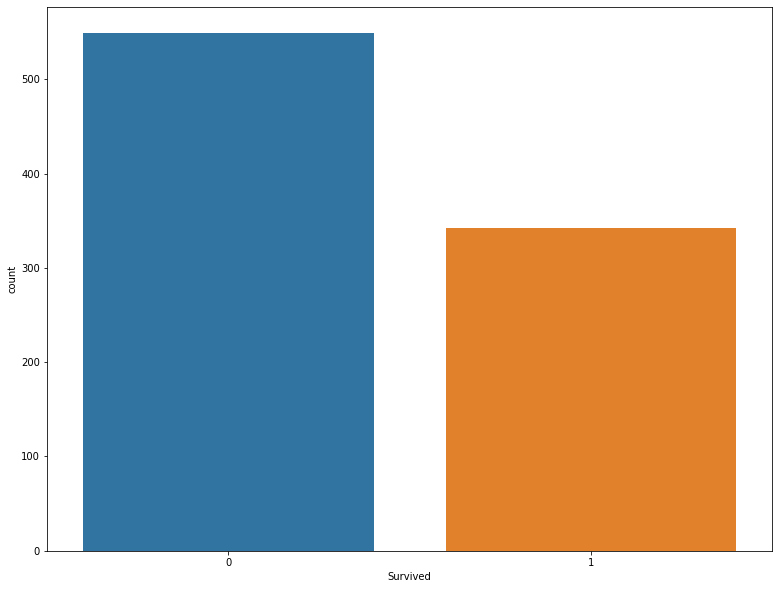

In [9]:
plt.figure(figsize=(13,10))
sns.countplot("Survived", data=train_data)

### Checking nulls

In [10]:
train_data.isna().mean().round(4) * 100

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

In [11]:
test_data.isna().mean().round(4)*100

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.57
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.24
Cabin          78.23
Embarked        0.00
dtype: float64

## Let's build our first model

We're gonna use the scikit-learn library for this. We are going to use a Random Forest Classifier which is a decision tree-based model.

In [12]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"] # We separate our target value (the one we want to predict)

features = ["Pclass", "Sex", "SibSp", "Parch"] # We will be using these columns to start with
X = pd.get_dummies(train_data[features]) # Get dummies performs one-hot encoding, making each element of a column a unique column, having 1 if a row has that value and 0 oherwise
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1) # Define the model
model.fit(X, y) # Train the model
predictions = model.predict(X_test) # Perform predictions on test set

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission_no_processing.csv', index=False)
files.download("submission_no_processing.csv")
print("Your submission was successfully saved!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Your submission was successfully saved!


We got an score of 0.77% of accuracy, not bad
But we didn't even processed our data, so let's get into that

### Filling nulls


We didn't use the "Age" columns because it wasn't complete and Random Forest doesn't accept null values

In [13]:
train_data["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

We saw in the data dictionary that Age can be less than 1, and estimated when it has .5

We can apply a function to transform all fractional ages to 1 and also to round the approximated ages (those with .5)

In [16]:
# we filter the non-null ages
train_data.loc[train_data["Age"].notnull() ,"Age"] = train_data.loc[train_data["Age"].notnull() ,"Age"].apply(lambda age: 1 if age < 1 else int(age))

One way is filling the values with the median age
```
train_data.loc[:,"Age"] = train_data["Age"].fillna(train_data["Age"].median())
````

In [17]:
# Another, and more elaborated, way is to fill with the median of the sex. We are going to use this one
male_median = train_data.loc[train_data["Sex"]=="male", "Age"].median()
female_median = train_data.loc[train_data["Sex"]=="female", "Age"].median()

train_data.loc[train_data["Sex"]=="male", "Age"] = train_data.loc[train_data["Sex"]=="male", "Age"].fillna(male_median,)
train_data.loc[train_data["Sex"]=="female", "Age"] = train_data.loc[train_data["Sex"]=="female", "Age"].fillna(female_median)

test_data.loc[test_data["Sex"]=="male", "Age"] = test_data.loc[test_data["Sex"]=="male", "Age"].fillna(male_median)
test_data.loc[test_data["Sex"]=="female", "Age"] = test_data.loc[test_data["Sex"]=="female", "Age"].fillna(female_median)

Also, the "Embarked" column has some nulls. Because the % is too low, we are going to use the median.

In [18]:
train_data["Embarked"].fillna(train_data["Embarked"].value_counts().index[0], inplace=True)
test_data["Embarked"].fillna(test_data["Embarked"].value_counts().index[0], inplace=True)

In [19]:
# In the test the column "Fare" has some nulls, let's use the mean because it's a continuous value
test_data["Fare"].fillna(test_data["Fare"].mean(), inplace=True)

Lets re-define the features

In [20]:
numerical_features = ["Age", "Fare", "Parch"]
categorical_features = ["Pclass", "Sex", "SibSp", "Embarked"]

In [21]:
train_data.isna().mean().round(4)*100

PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Cabin          77.1
Embarked        0.0
dtype: float64

In [22]:
test_data.isna().mean().round(4)*100

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age             0.00
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          78.23
Embarked        0.00
dtype: float64

In [23]:
dummies_train = pd.get_dummies(train_data[categorical_features]) # Perform one-hot encoding just to categorical columns, making each element of a column a unique column, having 1 if a row has that value and 0 oherwise
dummies_test = pd.get_dummies(test_data[categorical_features])

X = X = pd.concat([dummies_train, train_data[numerical_features]], axis=1)
X_test = pd.concat([dummies_test, test_data[numerical_features]], axis=1)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1) # Define the model
model.fit(X, y) # Train the model
predictions = model.predict(X_test) # Perform predictions on test set

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission_processed_data.csv', index=False)
files.download("submission_processed_data.csv")
print("Your submission was successfully saved!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Your submission was successfully saved!


And we can keep improving our model by better cleaning methods, creating new features based on the starting ones(like an age*fare ratio, adding age groups, etc)